**Описание данных**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

# План работы
- Изучить файл с данными.
- Проверить данные на пропуски, дубликаты, корреляцию.
- Визуализировать данные.
- Разбить данные на две выборки в соотношении 75:25 : обучающая, валидационная.
- Исследовать на трех датасетах модель регрессии: Линейная регрессия
- Найти оптимальные гиперпараметры для каждой модели, измерять метрику RMSE, R2.
- Подготовить данные к расчету прибыли и подсчету рисков
- Посчитать риски и прибыль для каждого региона

## Загрузка и подготовка данных

Импортируем библиотеки и прочтем файлы

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим датасеты по отдельности.

In [3]:
def check(data):
    data.info()
    for column in data.columns:
        print()
        print('\033[1mCтолбец\033[0m', column)
        print('Кол-во уникальных значений -',data[column].nunique())
        print('Кол-во пропусков -',data[column].isnull().sum())
        print('Кол-во дубликатов -', data[column].duplicated().sum())
        print()
        print(data[column].value_counts().head())
        print()

In [4]:
sns.set(palette='mako', context='talk',style='darkgrid')
def charts(data, column, title):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    plt.suptitle(title, fontsize = "xx-large")
    distplot = sns.distplot(data[column],ax=axs[0])
    sns.boxplot(data[column], ax=axs[1])
    

### Датасет № 1

In [5]:
check(data_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Cтолбец id
Кол-во уникальных значений - 99990
Кол-во пропусков - 0
Кол-во дубликатов - 10

HZww2    2
A5aEY    2
bxg6G    2
QcMuo    2
74z30    2
Name: id, dtype: int64


Cтолбец f0
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

-1.017607    1
 1.147603    1
-0.731757    1
-1.193550    1
 0.796797    1
Name: f0, dtype: int64


Cтолбец f1
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

0.675282    1
0.226651    1
0.824733    1
0.132691    1
0.507665    1
Name: f1, dtype: int64


Cтолбец f2
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

 2.163763    1
-0.828819 

In [6]:
data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [7]:
data_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


In [8]:
data_0[data_0['product']==0]

,id,f0,f1,f2,product
57263,zCM5W,-0.702064,0.375992,0.236572,0.0


In [9]:
data_0['product'].value_counts(normalize=True).head()

133.484532    0.00001
62.168021     0.00001
132.876558    0.00001
72.311385     0.00001
126.226062    0.00001
Name: product, dtype: float64

#### Корреляция

In [10]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [11]:
data_0.corr()[['product']].sort_values(by='product', ascending=False)

,product
product,1.000000
f2,0.483663
f0,0.143536
f1,-0.192356


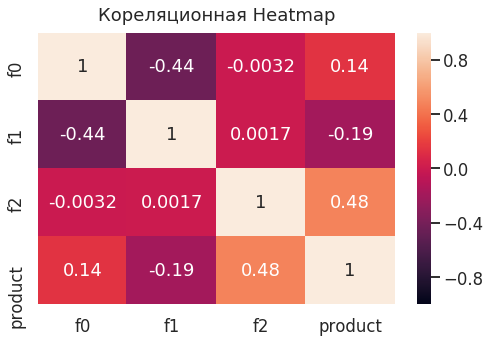

In [12]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(data_0.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Кореляционная Heatmap', fontdict={'fontsize':18}, pad=12);

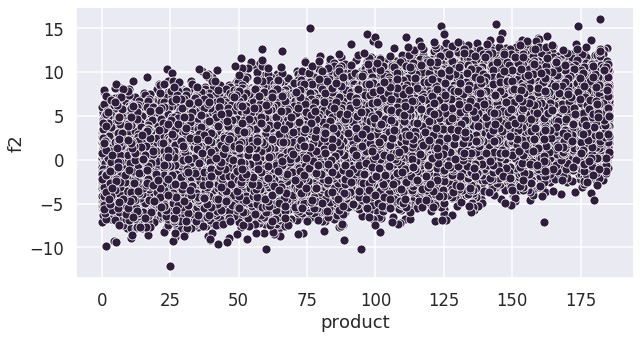

In [13]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data_0, x="product", y="f2")

#### Графики

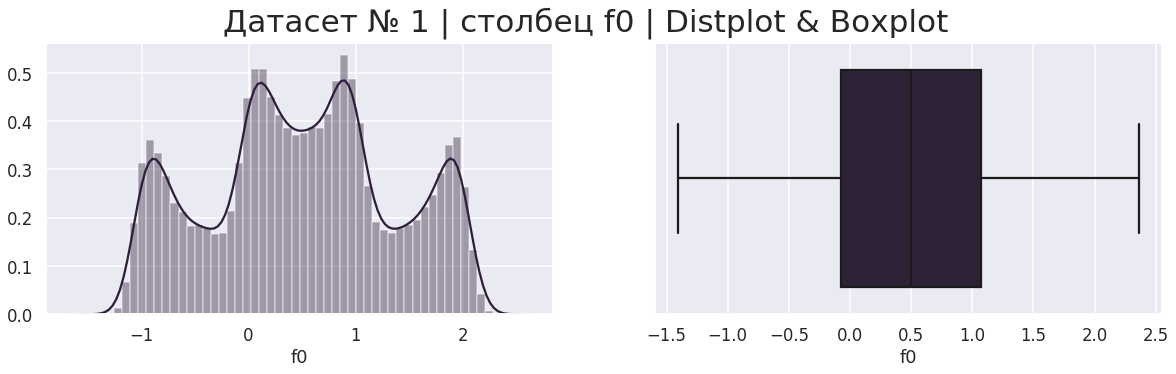

In [14]:
charts(data_0,'f0','Датасет № 1 | столбец f0 | Distplot & Boxplot')

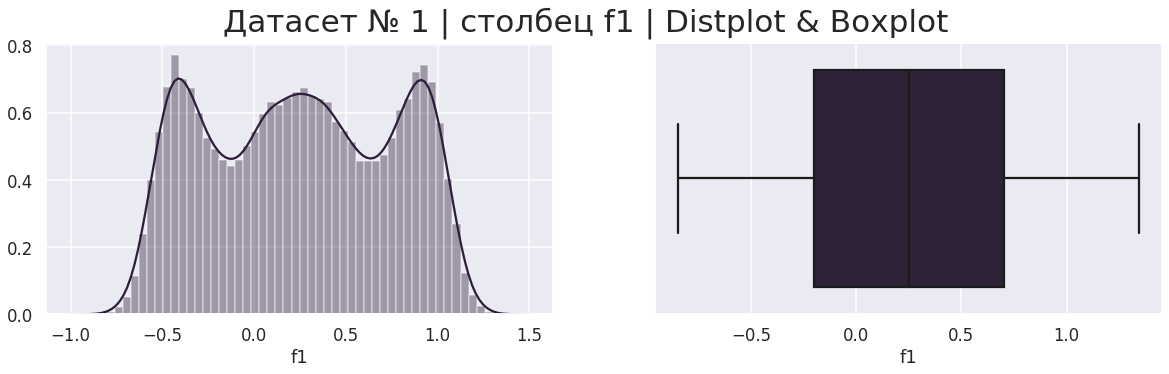

In [15]:
charts(data_0,'f1','Датасет № 1 | столбец f1 | Distplot & Boxplot')

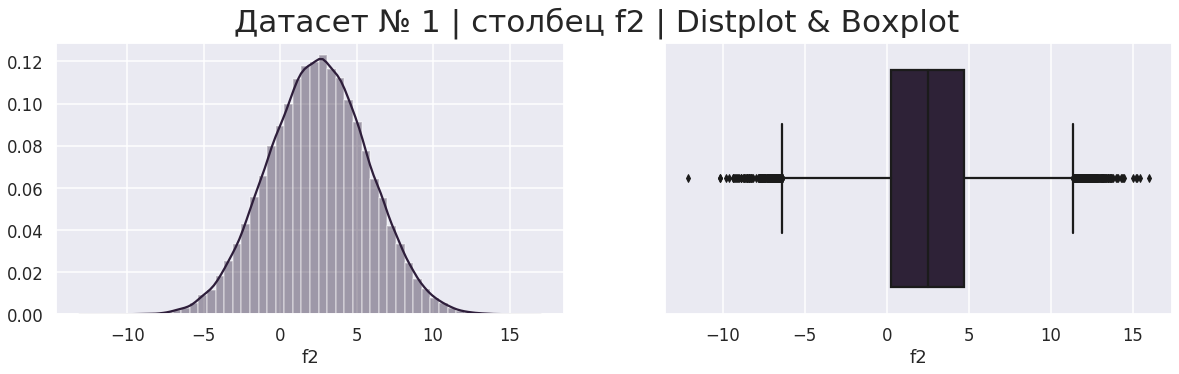

In [16]:
charts(data_0,'f2','Датасет № 1 | столбец f2 | Distplot & Boxplot')

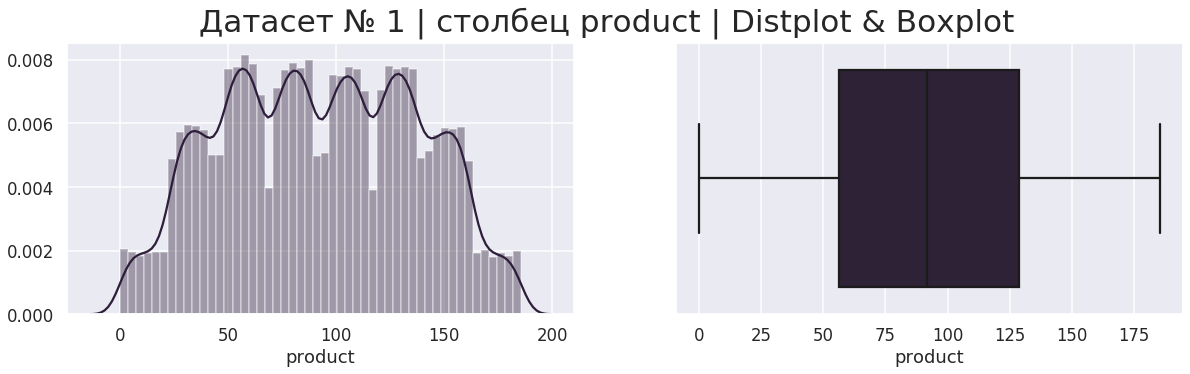

In [17]:
charts(data_0,'product','Датасет № 1 | столбец product | Distplot & Boxplot')

**Промежуточные выводы:** Имеются дубли id идентификаторов. Слабая корреляция (0.48) между значениями столбцов f2 и product

### Датасет № 2

In [18]:
check(data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Cтолбец id
Кол-во уникальных значений - 99996
Кол-во пропусков - 0
Кол-во дубликатов - 4

wt4Uk    2
LHZR0    2
bfPNe    2
5ltQ6    2
BBzv7    1
Name: id, dtype: int64


Cтолбец f0
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

-4.545515     1
 5.297343     1
-13.075676    1
 0.384176     1
 21.030916    1
Name: f0, dtype: int64


Cтолбец f1
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

-2.420454    1
-8.292583    1
-8.575602    1
-8.043060    1
-4.761843    1
Name: f1, dtype: int64


Cтолбец f2
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

 2.002652    1
-

In [19]:
data_1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [20]:
data_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


In [21]:
data_1[data_1['product']==0]

,id,f0,f1,f2,product
11,OXyvW,16.320755,-0.562946,-0.001783,0.0
13,igmai,6.695604,-0.749449,-0.007630,0.0
62,Qjy5w,21.418478,-5.134490,-0.002836,0.0
63,G6WCj,6.822701,3.104979,-0.000723,0.0
77,MzQhL,6.750150,-11.893512,-0.001601,0.0
...,...,...,...,...,...
99936,YrRU8,5.085749,-3.980305,0.005063,0.0
99948,Jbnur,8.277805,-9.178818,0.003275,0.0
99956,aV1cJ,13.343983,-1.290200,0.005980,0.0
99961,Zjbn2,13.854163,-11.528089,-0.005556,0.0


In [22]:
print('Процент нулевых значений: {:.2%}'.format(data_1[data_1['product'] == 0].shape[0]/data_1.shape[0]))

Процент нулевых значений: 8.24%


In [23]:
data_1['product'].value_counts(normalize=True)

53.906522     0.08472
26.953261     0.08468
84.038886     0.08431
57.085625     0.08390
3.179103      0.08337
80.859783     0.08320
30.132364     0.08306
134.766305    0.08304
110.992147    0.08303
0.000000      0.08235
137.945408    0.08233
107.813044    0.08201
Name: product, dtype: float64

#### Корреляция

In [24]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


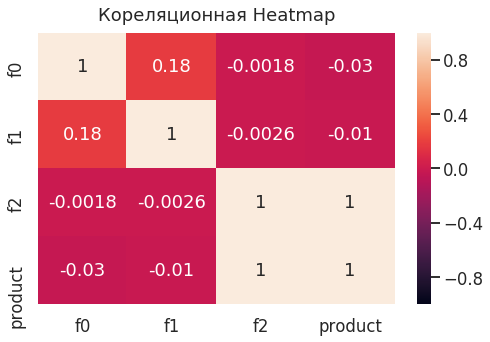

In [25]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(data_1.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Кореляционная Heatmap', fontdict={'fontsize':18}, pad=12);

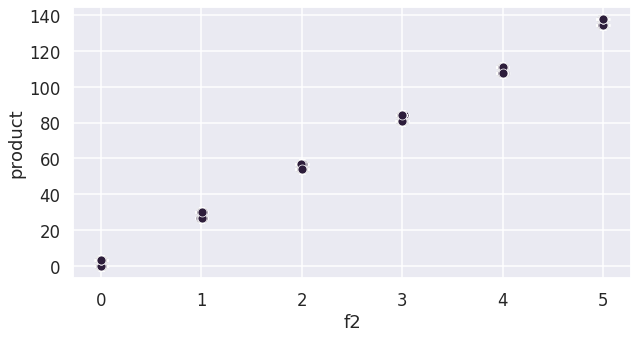

In [26]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data_1, x="f2", y="product")

#### Графики

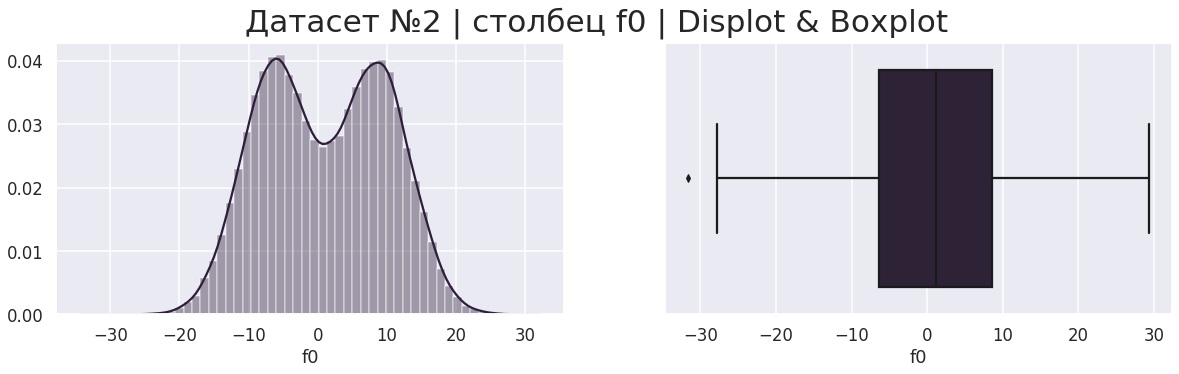

In [27]:
charts(data_1, 'f0', 'Датасет №2 | столбец f0 | Displot & Boxplot')

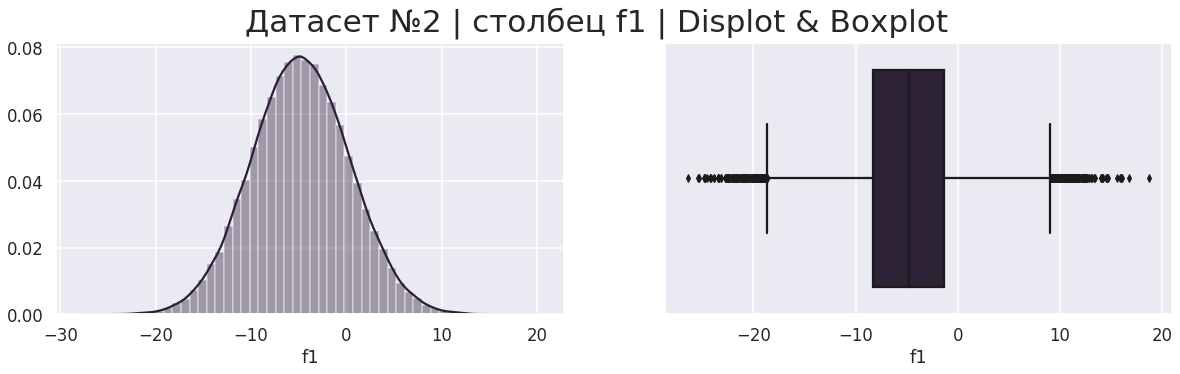

In [28]:
charts(data_1, 'f1', 'Датасет №2 | столбец f1 | Displot & Boxplot')

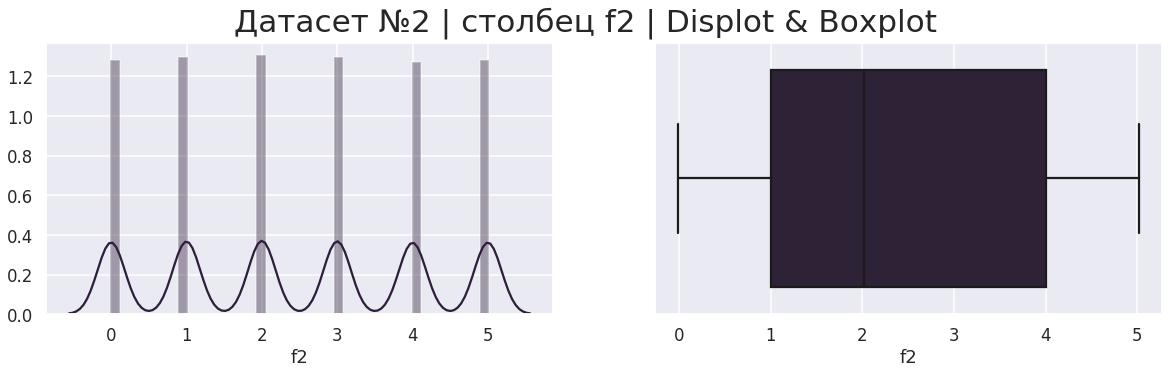

In [29]:
charts(data_1, 'f2', 'Датасет №2 | столбец f2 | Displot & Boxplot')

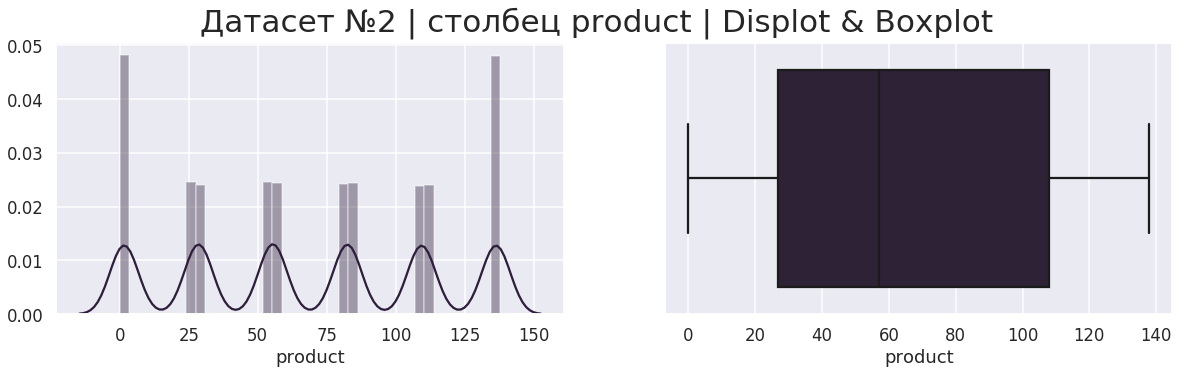

In [30]:
charts(data_1, 'product', 'Датасет №2 | столбец product | Displot & Boxplot')

**Промежуточные выводы:** Имеются дубли id идентификаторов. Кол-во уникальных значений в product - 12, очень странное значение, требуется уточнение откуда берутся данные и реальные ли они. Очень сильная корреляция (0.99) между значениями столбцов f2 и product. Пропусков нет

### Датасет № 3

In [31]:
check(data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Cтолбец id
Кол-во уникальных значений - 99996
Кол-во пропусков - 0
Кол-во дубликатов - 4

Vcm5J    2
xCHr8    2
VF7Jo    2
KUPhW    2
yLT9D    1
Name: id, dtype: int64


Cтолбец f0
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

-1.648445    1
 1.003758    1
-1.864906    1
-3.603933    1
 0.213231    1
Name: f0, dtype: int64


Cтолбец f1
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

-1.888663    1
 1.254449    1
-2.240571    1
 1.341936    1
 0.103396    1
Name: f1, dtype: int64


Cтолбец f2
Кол-во уникальных значений - 100000
Кол-во пропусков - 0
Кол-во дубликатов - 0

 5.256481    1
-1.473

In [32]:
data_2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


In [33]:
data_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


In [34]:
data_2[data_2['product']==0]

,id,f0,f1,f2,product
68149,qeefd,-0.865596,-1.615247,-4.126441,0.0


#### Корреляция

In [35]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


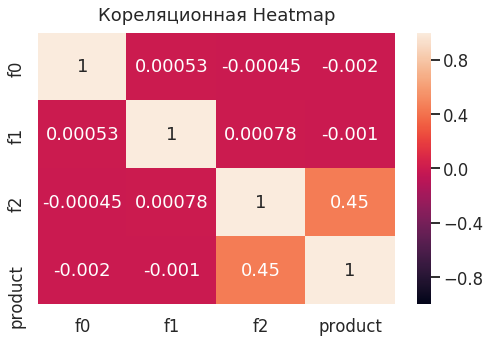

In [36]:
plt.figure(figsize=(8, 5))
heatmap = sns.heatmap(data_2.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Кореляционная Heatmap', fontdict={'fontsize':18}, pad=12);

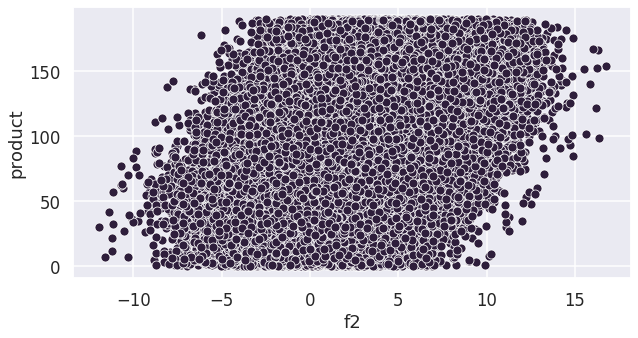

In [37]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data_2, x="f2", y="product")

#### Графики

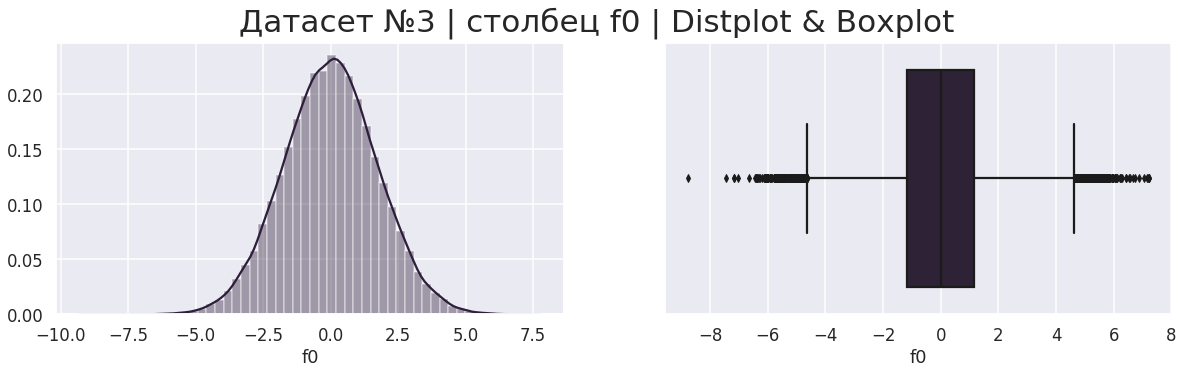

In [38]:
charts(data_2, 'f0', 'Датасет №3 | столбец f0 | Distplot & Boxplot')

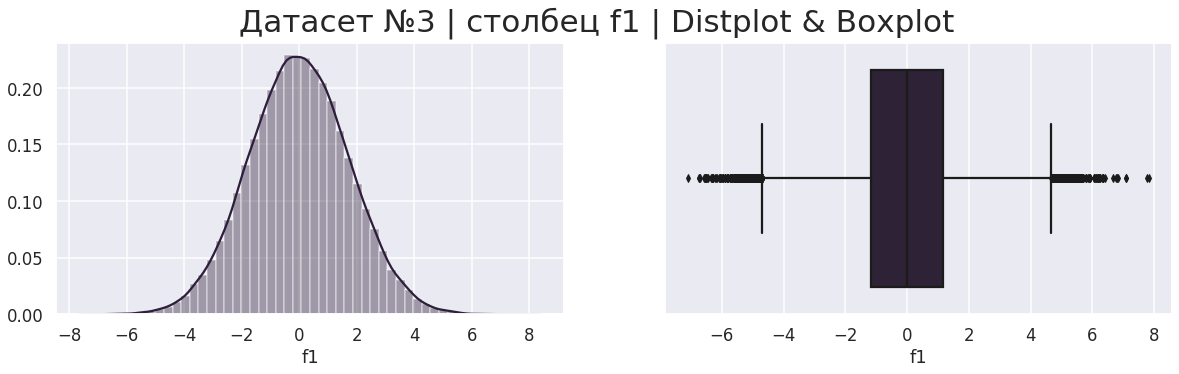

In [39]:
charts(data_2, 'f1', 'Датасет №3 | столбец f1 | Distplot & Boxplot')

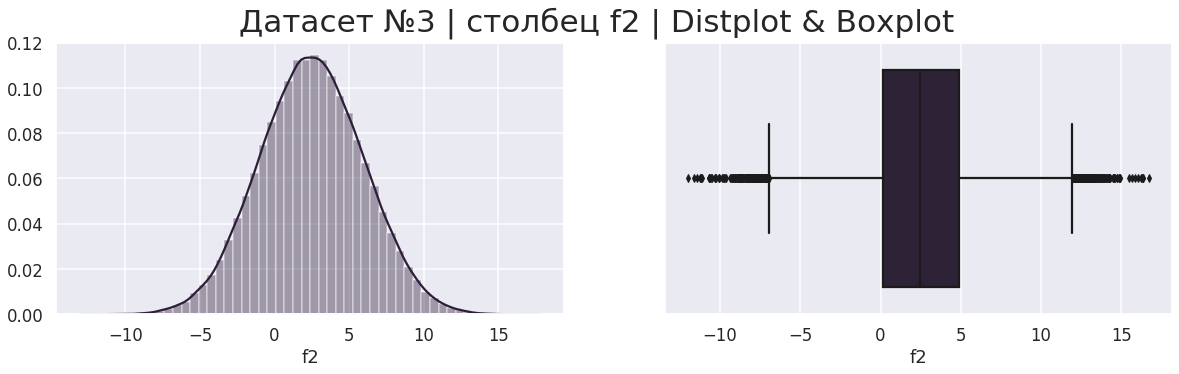

In [40]:
charts(data_2, 'f2', 'Датасет №3 | столбец f2 | Distplot & Boxplot')

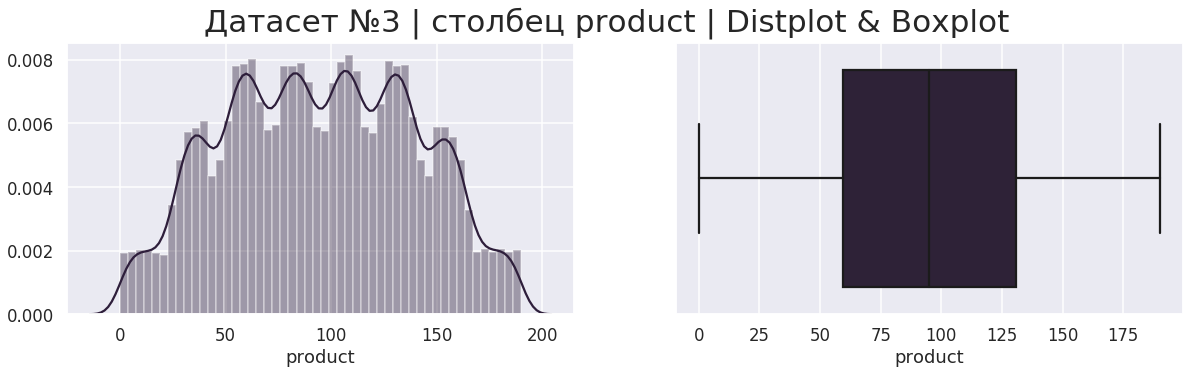

In [41]:
charts(data_2, 'product', 'Датасет №3 | столбец product | Distplot & Boxplot')

**Промежуточные выводы:** Имеются дубли id идентификаторов. Слабая корреляция (0.45) между значениями столбцов f2 и product. Пропусков нет

### Вывод

Ознакомились с тремя датасетами. Выявили слабую и сильную корреляцию между столбцами f2 и product. Из трех датасетов, датасет № 2 выделяется больше всех, в нем присутствуют всего 12 уникальных значений в столбце product, что вызывает вопросы о происхождении данных. Возможно, поэтому очень сильная корреляция между столбцами f2 product - 0.99.
Определим столбец product, как целевой признак,  а столбец id удалим, и приступим к обучению модели Линейной регрессии.

## Обучение и проверка модели

Напишем функцию для разделения данных на выборки, обучим модель и рассчитаем метрики.

In [42]:
def split_train(data, target_col):
    features = data.drop(['product', 'id'], axis=1)
    target = data['product']
    
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                            target, test_size=0.25, random_state=12345)
    
    print('Размер тренировчной выборки:',features_train.shape[0])
    print('Размер валидационной выборки:',features_valid.shape[0])
    print()
    
    param = {'fit_intercept':[True,False], 'copy_X':[True, False], 
                  'normalize':[True,False]}
    model = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5)
    #model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, prediction) ** 0.5)
    r2 = r2_score(target_valid, prediction)
    mean_predict = prediction.mean()
    
    print('RMSE:', round(rmse, 4))
    print('R2:', round(r2, 4))
    print('Средний запас предсказанного сырья:', round(mean_predict, 4))
    print()
    print('Наилучшие гиперпараметры:',model.best_params_)
    
    value = {}
    value['prediction'] = prediction
    value['target_valid'] = target_valid
    
    return value
    
target_col = 'product'

In [43]:
print('\033[1mДатасет № 1\033[0m')
reg_0 = split_train(data_0, target_col)

Датасет № 1
Размер тренировчной выборки: 75000
Размер валидационной выборки: 25000

RMSE: 37.5794
R2: 0.2799
Средний запас предсказанного сырья: 92.5926

Наилучшие гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'normalize': False}


In [44]:
print('\033[1mДатасет № 2\033[0m')
reg_1 = split_train(data_1, target_col)

Датасет № 2
Размер тренировчной выборки: 75000
Размер валидационной выборки: 25000

RMSE: 0.8931
R2: 0.9996
Средний запас предсказанного сырья: 68.7285

Наилучшие гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'normalize': True}


In [45]:
print('\033[1mДатасет № 3\033[0m')
reg_2 = split_train(data_2, target_col)

Датасет № 3
Размер тренировчной выборки: 75000
Размер валидационной выборки: 25000

RMSE: 40.0297
R2: 0.2052
Средний запас предсказанного сырья: 94.965

Наилучшие гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'normalize': True}


### Вывод

И так, мы провели разделение данных на обучающую и валидационную выборки в соотношении 75:25. Обучили модель и сделали предсказания на валидационной выборке. Посчитали средний запас предсказанного сырья и метрику RMSE и R2 модели, они составили:
- Датасет №1:
  RMSE: 37.5794
/ R2: 0.2799 
/ Среднее предсказанного сырья: 92.5926
- Датасет № 2:
  RMSE: 0.8931
/ R2: 0.9996
/ Среднее предсказанного сырья: 68.7285
- Датасет №3:
  RMSE: 40.0297
/ R2: 0.2052
/ Среднее предсказанного сырья: 94.965



В первом и третьем Датасете метрика R2 довольно низкая. А в Датасете №2 R2 = 0.9996, такой высокий коэффициент скорей всего связан с тем, что имеется очень сильная корреляция целевого признака (product) с признаком ‘f2'.


Что касается метрики RMSE, чем ближе её значение к нулю тем лучше.
Датасет № 2 опять лидирует, имеет показатель со значением  RMSE: 0.8931, далее идет Датасет №1 - RMSE: 37.5794 и Датасет № 3 - RMSE: 40.0297.

Определили наилушчие гиперпараметры для моделей:
Датасет №1 - {'copy_X': True, 'fit_intercept': True, 'normalize': False}
Датасет №2 - {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Датасет №3 - {'copy_X': True, 'fit_intercept': True, 'normalize': True}


## Подготовка к расчёту прибыли

Сохраним все ключивые значения для расчета и рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [46]:
budget = 10**10 # бюджет 10 млрд. руб.
price_one_th_barells = 450 * 10**3 #цена за 1 тыс. барреллей
number_of_oil_wells = 200 #скважен для разработки
price_for_one_well = budget / number_of_oil_wells #цена за 1 сважену

In [47]:
break_even_point = price_for_one_well / price_one_th_barells
print('Достаточный объём сырья:', round(break_even_point,3))

Достаточный объём сырья: 111.111


In [48]:
reg_data_0 = pd.DataFrame(reg_0['target_valid'])
reg_data_0['prediction'] = reg_0['prediction']
reg_data_0['profit'] = reg_0['target_valid'] * price_one_th_barells
reg_data_0['region'] = 0

reg_data_1 = pd.DataFrame(reg_1['target_valid'])
reg_data_1['prediction'] = reg_1['prediction']
reg_data_1['profit'] = reg_1['target_valid'] * price_one_th_barells
reg_data_1['region'] = 1

reg_data_2 = pd.DataFrame(reg_2['target_valid'])
reg_data_2['prediction'] = reg_2['prediction']
reg_data_2['profit'] = reg_2['target_valid'] * price_one_th_barells
reg_data_2['region'] = 2

In [49]:
oil_wells = pd.concat([reg_data_0, reg_data_1, reg_data_2])
oil_wells.pivot_table(index='region').sort_values(by='prediction', ascending= False)

,prediction,product,profit
region,,,
2,94.965046,94.884233,4.269790e+07
0,92.592568,92.078597,4.143537e+07
1,68.728547,68.723136,3.092541e+07


### Вывод

Осуществили подготовку к расчету прибыли и определи точку безубыточности необходимого объёма сырья - 111 тыс. баррелей. Стоит отметить, что запасов сырья в скважинах меньше, чем точка безубыточности.

## Расчёт прибыли по выбранным скважинам и предсказаниям модели 

In [50]:
def revenue(data):
    target = data['product']
    prediction = data['prediction']
    best_predictions = prediction.sort_values(ascending=False)[:200].index
    selected = target[best_predictions]
    revenue = ((selected.sum() * price_one_th_barells) - budget) / 10**9
    print('Целевое значение объёма сырья', round(selected.sum(),3), 'тыс.бареллей')
    print('Прибыль для полученного объема сырья:', round(revenue,3), 'млрд.руб.')

In [51]:
print('\033[1mДатасет №1\033[0m')
revenue(reg_data_0)

Датасет №1
Целевое значение объёма сырья 29601.836 тыс.бареллей
Прибыль для полученного объема сырья: 3.321 млрд.руб.


In [52]:
print('\033[1mДатасет №2\033[0m')
revenue(reg_data_1)

Датасет №2
Целевое значение объёма сырья 27589.082 тыс.бареллей
Прибыль для полученного объема сырья: 2.415 млрд.руб.


In [53]:
print('\033[1mДатасет №3\033[0m')
revenue(reg_data_2)

Датасет №3
Целевое значение объёма сырья 28245.222 тыс.бареллей
Прибыль для полученного объема сырья: 2.71 млрд.руб.


### Вывод

Выбрали скважины с максимальным значениями предсказаний и отобрали по 200 скважин в каждом регионе. Просуммировали реальные данные по этим скважинам. Рассчитали прибыль для полученного объёма и получили следующие результаты:
- Датасет №1
    - Целевое значение объёма сырья 29601.836 тыс.бареллей
    - Прибыль для полученного объема сырья: 3.321 млрд.руб.

- Датасет №2
    - Целевое значение объёма сырья 27589.082 тыс.бареллей
    - Прибыль для полученного объема сырья: 2.415 млрд.руб.
- Датасет №3
    - Целевое значение объёма сырья 28245.222 тыс.бареллей
    - Прибыль для полученного объема сырья: 2.71 млрд.руб.


Для полученного объёма сырья прибыль составит от 2,4 до 3,32 млрд. рублей.

## Посчитайте риски и прибыль для каждого региона

In [54]:
def bootstrap(data_reg):

    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        data = data_reg.sample(n=500, random_state=state, replace = True)
        best_pred = data.sort_values(by='prediction',ascending=False)[:200]
        income = (best_pred['profit'].sum() - budget) / 10**9
        values.append(income)
    values = pd.Series(values)
    lower = values.quantile(0.025)
    higher = values.quantile(0.975)
    loss = values[values<0]
    mean = values.mean()
    print('Кол-во эксперементов:', len(values))
    print('Средняя прибыль: {:.4f} млрд. руб.'.format(mean))
    print()
    print('Квантиль 2,5%: {:.4f}.'.format(lower))
    print('Квантиль 97,5%: {:.4f}'.format(higher))
    print()
    print('Риск убытков: {:.2%}'.format(loss.count() / len(values)))
    print('Максимальный убыток: {:.4f} млрд.руб.'.format(loss.min()))
    print('Максимальная прибыль: {:.4f} млрд.руб'.format(values.max()))

In [55]:
print('\033[1mДатасет № 1\033[0m')
bootstrap(reg_data_0)

Датасет № 1
Кол-во эксперементов: 1000
Средняя прибыль: 0.3962 млрд. руб.

Квантиль 2,5%: -0.1112.
Квантиль 97,5%: 0.9098

Риск убытков: 6.90%
Максимальный убыток: -0.3696 млрд.руб.
Максимальная прибыль: 1.3493 млрд.руб


In [56]:
print('\033[1mДатасет № 2\033[0m')
bootstrap(reg_data_1)

Датасет № 2
Кол-во эксперементов: 1000
Средняя прибыль: 0.4560 млрд. руб.

Квантиль 2,5%: 0.0338.
Квантиль 97,5%: 0.8523

Риск убытков: 1.50%
Максимальный убыток: -0.1923 млрд.руб.
Максимальная прибыль: 1.1540 млрд.руб


In [57]:
print('\033[1mДатасет № 3\033[0m')
bootstrap(reg_data_2)

Датасет № 3
Кол-во эксперементов: 1000
Средняя прибыль: 0.4044 млрд. руб.

Квантиль 2,5%: -0.1634.
Квантиль 97,5%: 0.9504

Риск убытков: 7.60%
Максимальный убыток: -0.4179 млрд.руб.
Максимальная прибыль: 1.3306 млрд.руб


### Вывод

Итак, мы применили технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Для каждого Датасета нашли среднюю прибыль и процент риска убытков. 
- Получили следующие результаты:

    - Датасет№1 
/ Средняя прибыль: 0.3962 млрд. руб.
/ Риск убытков: 6.90%

    - Датасет №2
/ Средняя прибыль: 0.4560 млрд. руб.
/ Риск убытков: 1.50%

    - Датасет № 3
/ Средняя прибыль: 0.4044 млрд. руб.
/ Риск убытков: 7.60%

## Общий вывод

Для решения поставленной задачи, а именно - решить, где бурить новую скважину, мы ознакомились, подготовили и обработали данные для осуществления машинного обучения и подсчета прибыльности каждого из регионов.
Основное наблюдение на стадии ознакомления является очень сильная корреляция в Датасете №2 между целевым признаком (product) с признаком ‘f2’. 
Далее мы обучили модель Линейной регрессии на трех датасетах и выявили наилучшие гипермараметры.
- Наилучшие гиперпараметры:

   - Датасет №1 - {'copy_X': True, 'fit_intercept': True, 'normalize': False} 
   - Датасет №2 - {'copy_X': True, 'fit_intercept': True, 'normalize': True} 
   - Датасет №3 - {'copy_X': True, 'fit_intercept': True, 'normalize': True}
   

- Рассчитали необходимые метрики RMSE, R2 и среднее предсказанного сырья:

    - Датасет №1: RMSE: 37.5794 / R2: 0.2799 / Среднее предсказанного сырья: 92.5926
    - Датасет № 2: RMSE: 0.8931 / R2: 0.9996 / Среднее предсказанного сырья: 68.7285
    - Датасет №3: RMSE: 40.0297 / R2: 0.2052 / Среднее предсказанного сырья: 94.965


- Определи точку безубыточности необходимого объёма сырья, она составили - 111 тыс. баррелей. 


- Выбрали скважины с максимальным значениями предсказаний и отобрали по 200 скважин в каждом регионе и выявили, что из имеющих данных по трем регионам прогнозируемая прибыль составит от 2,4 до 3,32 млрд. рублей. (Датасет № 1 с наибольшей прибылью, с наименьшей Датасет №2)


- Также, провели Bootstrap и определили риски убытков:
    - Датасет№1 - Риск убытков: 6.90%
    - Датасет №2  - Риск убытков: 1.50%
    - Датасет № 3 - Риск убытков: 7.60%

Итог: Прежде чем, выносить решение стоит уточнить информацию о данных из Датасета №2. Все рассчитанные метрики, в плоть до рисков делают этот регион самым приоритетным. Если же, данные окажутся ненадежными, то стоит выбрать регион из Датасета № 1. У него наибольшее целевое значение объёма сырья — 29601.836 тыс. баррелей и прогнозируем прибыль для полученного объема сырья — 3.321 млрд.руб., а риск убытка на 0.7% меньше чем у Датасета №3.

